# Passive Sonar Classification
Este notebook tem por objetivo o treinamento de modelos de sonar passivo

In [1]:
import os
import warnings
from scipy import signal
from scipy.signal import decimate, convolve, spectrogram, lfilter, cheby2, butter, cheb2ord, hilbert
from librosa import stft, fft_frequencies, frames_to_time, feature
import numpy as np
import math
import pandas as pd
import soundfile as sf
import pandas as pd

import SonarFunctions

## Carga de Arquivos

In [2]:
import os
from os import walk

database = '4classes' # 4classes or shipsEar # este conjunto já está no formato padrão.
# uma pasta por classe.

file_folder = "./data/raw" # alterar para o ponto onde os dados crus estão armazenados

file_path = os.path.join(file_folder, database)

dict_classes = {} # dicionario com todos os nomes dos arquivos organizados 

f = []
for (dirpath, dirnames, filenames) in walk(top=file_path,topdown=True):
    if filenames == []: # lista de arquivos vazia
        continue
    filenames.sort()
    dict_classes[dirpath.split('/')[-1]] = {}
    for filename in filenames:
        #print(filename)
        # preciso pegar cada um dos arquivos e separar por classe
        dict_classes[dirpath.split('/')[-1]][filename.split('.')[0]] = os.path.join(dirpath,filename)

In [3]:
# célula onde o processamento é realizada
df_all_data = None

for iclass in dict_classes.keys():
    for irun in dict_classes[iclass].keys():
        df_run = pd.DataFrame()
        #print(dict_classes[iclass][irun].split('.'))
        if dict_classes[iclass][irun].split('.')[2] == 'wav':
            signal, fs = sf.read(dict_classes[iclass][irun])
        else:
            print('Não está no formato correto')
            continue
        
        decimate_ratio = 1 #1, 3, 4
        if decimate_ratio != 1:
            signal = decimate(signal,decimate_ratio)
        
        lofar_signal, freq, time = SonarFunctions.lofar(data=signal,fs=fs, n_pts_fft=1024,
                                                        n_overlap=0.0, spectrum_bins_left=400)
        print('Processing Class: %s - Run: %s'%(iclass,irun))
        df_run['fs'] = fs*np.ones([lofar_signal.shape[0]])
        df_run['filename'] = dict_classes[iclass][irun]
        df_run['run'] = irun
        df_run['class'] = iclass
        df_lofar_signal = pd.DataFrame(lofar_signal)
        df_lofar_signal = df_lofar_signal.add_prefix('bin_')
        df_run = pd.concat([df_run, df_lofar_signal], axis=1)  
        if df_all_data is None:
            df_all_data = df_run
        else:
            df_all_data = pd.concat([df_all_data,df_run],axis=0, ignore_index=True)

Processing Class: Class1 - Run: navio10
Processing Class: Class1 - Run: navio11
Processing Class: Class1 - Run: navio12
Processing Class: Class1 - Run: navio13
Processing Class: Class1 - Run: navio14
Processing Class: Class2 - Run: navio20
Processing Class: Class2 - Run: navio21
Processing Class: Class2 - Run: navio22
Processing Class: Class2 - Run: navio23
Processing Class: Class2 - Run: navio24
Processing Class: Class2 - Run: navio25
Processing Class: Class2 - Run: navio26
Processing Class: Class2 - Run: navio27
Processing Class: Class2 - Run: navio28
Processing Class: Class2 - Run: navio29
Processing Class: Class3 - Run: navio30
Processing Class: Class3 - Run: navio31
Processing Class: Class3 - Run: navio32
Processing Class: Class3 - Run: navio33
Processing Class: Class3 - Run: navio34
Processing Class: Class3 - Run: navio35
Processing Class: Class3 - Run: navio37
Processing Class: Class3 - Run: navio38
Processing Class: Class3 - Run: navio39
Processing Class: Class4 - Run: navio40


In [4]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_390,bin_391,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.335194,0.290565,0.000000,0.000000,-0.095023,0.207849,0.172270,0.000000,-0.188387,0.000000
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,-0.020954,0.272748,0.110898,-0.092722,-0.038747,0.113801,-0.152823,-0.117272,0.163662,0.137150
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,-0.051785,0.196819,0.117354,0.000000,0.000000,-0.189164,0.032740,0.303563,0.275072,-0.017150
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.122398,0.338626,0.146549,-0.115717,0.174938,0.124910,0.111019,0.109464,-0.177160,-0.017336
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,0.350771,-0.168812,-0.176851,0.015273,0.319997,0.069744,-0.189101,0.056269,0.000000,-0.048143


In [5]:
# adicionando a coluna target
classes = df_all_data['class'].unique()
classes.sort()
df_all_data['target']=-1
for iclass, class_value in enumerate(classes):
    df_all_data.loc[df_all_data['class']==class_value,'target']=iclass

# criando uma chave única por janela
df_all_data['window_id'] = df_all_data.index

In [6]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399,target,window_id
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.000000,0.000000,-0.095023,0.207849,0.172270,0.000000,-0.188387,0.000000,0,0
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0.110898,-0.092722,-0.038747,0.113801,-0.152823,-0.117272,0.163662,0.137150,0,1
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0.117354,0.000000,0.000000,-0.189164,0.032740,0.303563,0.275072,-0.017150,0,2
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.146549,-0.115717,0.174938,0.124910,0.111019,0.109464,-0.177160,-0.017336,0,3
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,-0.176851,0.015273,0.319997,0.069744,-0.189101,0.056269,0.000000,-0.048143,0,4


# Validação Cruzada

## Validação cruzada por janela

A validação cruzada por janela é a validação cruzada mais aleatória que podemos fazer no caso de uma aplicação de sonar passivo, mas, infelizmente, ela mistura diferentes condições de máquina numa mesmo fold. Isso pode fazer com que os resultados dos modelos sejam enviezados e estamos começando a ambandonar esse método de avaliação


Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**window_cv_is_train_fold_X**), para validação (**window_cv_is_valid_fold_X**) e para teste (**window_cv_is_test**)

In [7]:
# seleção do conjunto de teste - conjunto nunca visto durante o processo de desenvolvimento
from sklearn.model_selection import StratifiedKFold

n_folds = 10

trgt = df_all_data['target'].values
data = df_all_data.filter(like='bin_').values

df_all_data['window_cv_is_test'] = 0

skf = StratifiedKFold(n_splits=n_folds)
for train_index, test_index in skf.split(data, trgt):
    df_all_data.loc[test_index,'window_cv_is_test'] = 1
    break

In [8]:
# seleção dos conjuntos de desenvolvimento - conjuntos que podem permutar durante o desenvolvimento
from sklearn.model_selection import StratifiedKFold

df_dev_data = df_all_data[df_all_data['window_cv_is_test'] == 0].copy(deep=True)
df_dev_data.reset_index(inplace=True)


trgt = df_dev_data['target'].values
data = df_dev_data.filter(like='bin_').values

df_dev_data = df_dev_data.loc[:, ['window_id']]

skf = StratifiedKFold(n_splits=n_folds)

for ifold,(train_index, valid_index) in enumerate(skf.split(data, trgt)):
    df_dev_data['window_cv_is_train_fold_%i'%(ifold)] = 0
    df_dev_data['window_cv_is_valid_fold_%i'%(ifold)] = 0

    df_dev_data.loc[train_index,'window_cv_is_train_fold_%i'%(ifold)] = 1
    df_dev_data.loc[valid_index,'window_cv_is_valid_fold_%i'%(ifold)] = 1

df_all_data = df_all_data.merge(df_dev_data, how='outer', on='window_id')

df_all_data.fillna(0,inplace=True)

In [9]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,window_cv_is_train_fold_5,window_cv_is_valid_fold_5,window_cv_is_train_fold_6,window_cv_is_valid_fold_6,window_cv_is_train_fold_7,window_cv_is_valid_fold_7,window_cv_is_train_fold_8,window_cv_is_valid_fold_8,window_cv_is_train_fold_9,window_cv_is_valid_fold_9
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Validação cruzada por corrida

A validação cruzada por corrida ou LORO é a validação cruzada que leva em consideração que janelas de geradas pela mesma corrida não podem estar em conjuntos diferentes. Isso pode fazer com que os resultados dos modelos sejam menos enviezados e este é o novo padrão do grupo sonar

Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**loro_cv_is_train_fold_X**), para validação (**loro_cv_is_valid_fold_X**) e para teste (**loro_cv_is_test**)

In [10]:
# to be done

# Treinamento

In [19]:
from sklearn.metrics import precision_recall_fscore_support

def get_model_result(df_predict, number_of_classes):
    
    res = []
    for l in range(number_of_classes):
        prec,recall,_,_ = precision_recall_fscore_support(df_predict['target']==l,
                                                          df_predict['prediction']==l,
                                                          pos_label=True,average=None)
        res.append([l,recall[0],recall[1]])

    model_res = pd.DataFrame(res,columns = ['class','specificity','sensitivity'])
    return model_res
#sp_index = np.sqrt((np.prod(model_res['sensitivity'])**(1/model_res.shape[0]))*np.mean(model_res['sensitivity']))
#model_res['SP_index'] = sp_index

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from joblib import dump, load
import keras

import Models

cv_method = 'window'
model_kind = 'kMeans'

ineuron = 10 # por exemplo

# criar um local para salvar o modelo
model_folder = './data/models' # alterar para onde os modelos serão salvos depois de treinados

hash_id = hash('%s_%s'%(cv_method, model_kind))

#neurons= [10, 15, 20, 25, 30] # alterar para a quantidade a ser analisada
neurons= [10] # alterar para a quantidade a ser analisada

for ifold in [0]:#np.arange(n_folds):
    print('Processing fold ',ifold)

    # pre-process data
    # filtragem de banco
    trn_input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
    val_input_data = df_all_data[df_all_data['%s_cv_is_valid_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
  
    # obter os alvos
    trn_trgt_data = trn_input_data['target'].values
    val_trgt_data = val_input_data['target'].values
    
    # filtro as caracteristicas
    trn_input_data = trn_input_data.filter(like='bin_').values
    val_input_data = val_input_data.filter(like='bin_').values

    # treinamento do normalizador
    scaler = StandardScaler()
    scaler.fit(trn_input_data)
    processed_trn_data = scaler.transform(trn_input_data)
    processed_val_data = scaler.transform(val_input_data)

    # concatenar o conjunto de treinamento e validação e gerar indices para treinar
    trn_idx = np.arange(0,processed_trn_data.shape[0])
    val_idx = np.arange(processed_trn_data.shape[0]+1,
                        processed_trn_data.shape[0]+processed_val_data.shape[0])
    
    trn_data = np.concatenate([processed_trn_data, processed_val_data])
    trn_trgt = np.concatenate([trn_trgt_data, val_trgt_data])
    
    
    trn_trgt = keras.utils.to_categorical(trn_trgt)
    for ineuron in neurons:
        model_name = '%s_%s_%s_cv_%i_fold_%i_neurons.jbl'%(hash_id, model_kind, cv_method, ifold, ineuron)
        print('Processing Neuron: ',ineuron)
        if not os.path.exists(os.path.join(model_folder,model_name)):
            print('Training...')
            model = KMeans(n_clusters=ineuron, random_state=0, init='k-means++', n_init=3) # cria o modelo

            #model.fit(processed_data) 
            # treinamento o modelo
            model.fit(processed_trn_data) # treinamento do modelo
            print('Saving model %s'%os.path.join(model_folder,model_name))
            #model.save(os.path.join(model_folder,model_name)) # salvar modelo da classe
            dump(model, os.path.join(model_folder,model_name)) # salvar o modelo vindo do sklearn
            predictions = model.predict(trn_data)
            df_predict = pd.DataFrame(data=np.concatenate((np.argmax(trn_trgt,axis=1)[:,np.newaxis], 
                                                           predictions[:,np.newaxis],
                                                           #np.argmax(predictions,axis=1)[:,np.newaxis]
                                                          ),
                                                          axis=1), 
                                      columns=['target', 'output'])
            prediction_name = model_name.replace('.jbl','_predictions.csv')
            df_predict.to_csv(os.path.join(model_folder, prediction_name),index=False)
            print('done')
        else:
            print('Model %s already trained...'%os.path.join(model_folder,model_name))

Processing fold  0
Processing Neuron:  10
Training...
Saving model ./data/models/7738791823965431455_kMeans_window_cv_0_fold_10_neurons.jbl
done


In [35]:
df_predict

,output
target,
0,11645
1,26416
2,10359
3,21384


In [258]:
# rodar depois de treinar
cv_method = 'window'
model_kind = 'MLPNeuralNetwork'

hash_id = hash('%s_%s'%(cv_method, model_kind))

neurons = [10, 15, 20, 25, 30] # alterar para a quantidade a ser analisada

df_all_results = None

for ifold in np.arange(n_folds):
    print('Processing fold ',ifold)
    for ineuron in neurons:
        model_name = '%s_%s_%s_cv_%i_fold_%i_neurons.jbl'%(hash_id, model_kind, cv_method, ifold, ineuron)
        print('Processing Neuron: ',ineuron)
        prediction_name = model_name.replace('.jbl','_predictions.csv')
        df_predict = pd.read_csv(os.path.join(model_folder, prediction_name))
        df_result = get_model_result(df_predict, number_of_classes=4)
        buffer = {}
        buffer['kind'] = '%s_%s_%i_neurons'%(cv_method, model_kind, ineuron)
        buffer['fold'] = ifold
        
        for iclass in range(4):
            buffer['res_Class%i_sensitivity'%(iclass)] = df_result[df_result['class']==iclass]['sensitivity'].values[0]
            buffer['res_Class%i_specificity'%(iclass)] = df_result[df_result['class']==iclass]['specificity'].values[0]
        sp_index = np.sqrt((np.prod(df_result['sensitivity'])**(1/df_result.shape[0]))*np.mean(df_result['sensitivity']))
        buffer['res_SP_index'] = sp_index
        buffer['res_Acc'] = Models.acc_score(df_predict['target'].values, df_predict['prediction'].values)
        if df_all_results is None:
            df_all_results = pd.DataFrame([buffer])
        else:
            df_all_results = pd.concat([df_all_results,pd.DataFrame([buffer])],axis=0, ignore_index=True)
            

Processing fold  0
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  1
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  2
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  3
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  4
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  5
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  6
Processing Neuron:  10
Processing Neuron:  15
Processing Neuron:  20
Processing Neuron:  25
Processing Neuron:  30
Processing fold  7
Processing Neuron:  10
Processing Neuron:  

In [256]:
df_predict

,target,nn_output,prediction
0,0.0,0.422396,0.0
1,0.0,0.878334,0.0
2,0.0,0.712002,3.0
3,0.0,0.405926,0.0
4,0.0,0.387021,0.0
...,...,...,...
69799,3.0,0.806872,3.0
69800,3.0,0.324508,3.0
69801,3.0,0.780036,3.0
69802,3.0,0.483091,3.0


In [259]:
df_all_results

,kind,fold,res_Class0_sensitivity,res_Class0_specificity,res_Class1_sensitivity,res_Class1_specificity,res_Class2_sensitivity,res_Class2_specificity,res_Class3_sensitivity,res_Class3_specificity,res_SP_index,res_Acc
0,window_MLPNeuralNetwork_10_neurons,0,0.722799,0.974209,0.914824,0.846179,0.557390,0.966776,0.853535,0.937092,0.755498,0.810971
1,window_MLPNeuralNetwork_15_neurons,0,0.708974,0.976857,0.886470,0.885936,0.620620,0.951350,0.868219,0.918443,0.766948,0.811816
2,window_MLPNeuralNetwork_20_neurons,0,0.719794,0.975051,0.846078,0.930073,0.642437,0.951081,0.918397,0.888786,0.777944,0.816945
3,window_MLPNeuralNetwork_25_neurons,0,0.792357,0.964184,0.891429,0.884046,0.599961,0.962520,0.872334,0.941801,0.784370,0.825798
4,window_MLPNeuralNetwork_30_neurons,0,0.740833,0.978249,0.829535,0.934498,0.618786,0.960602,0.935793,0.867947,0.776785,0.816013
5,window_MLPNeuralNetwork_10_neurons,1,0.754487,0.967021,0.898357,0.880981,0.640602,0.946270,0.841844,0.950991,0.780682,0.818793
6,window_MLPNeuralNetwork_15_neurons,1,0.744010,0.968552,0.903619,0.873536,0.651704,0.949029,0.838244,0.953573,0.781430,0.819581
7,window_MLPNeuralNetwork_20_neurons,1,0.766681,0.966849,0.913954,0.853831,0.444444,0.982000,0.898616,0.926208,0.741490,0.815011
8,window_MLPNeuralNetwork_25_neurons,1,0.762903,0.970581,0.927203,0.831705,0.597258,0.963176,0.810092,0.964581,0.769600,0.814953
9,window_MLPNeuralNetwork_30_neurons,1,0.758008,0.972008,0.910547,0.855283,0.514046,0.969283,0.874953,0.934820,0.755357,0.815354


In [260]:
df_consolidate_results = None
for ikind in df_all_results['kind'].unique():
    buffer = {}
    buffer['kind'] = '%s %s'%(ikind.split('_')[2],ikind.split('_')[3]) 
    for ifigure_of_merit in df_all_results.filter(like='res_').keys():
        buffer[ifigure_of_merit.replace('res_','')] = '%1.1f%%+/- %1.1f%%'%(100.0*df_all_results[df_all_results['kind'] == ikind][ifigure_of_merit].mean(),
                                                                         100.*df_all_results[df_all_results['kind'] == ikind][ifigure_of_merit].std()
                                                                        )
    if df_consolidate_results is None:
        df_consolidate_results = pd.DataFrame([buffer])
    else:
        df_consolidate_results = pd.concat([df_consolidate_results,pd.DataFrame([buffer])],axis=0, ignore_index=True)
        

In [261]:
df_consolidate_results

,kind,Class0_sensitivity,Class0_specificity,Class1_sensitivity,Class1_specificity,Class2_sensitivity,Class2_specificity,Class3_sensitivity,Class3_specificity,SP_index,Acc
0,10 neurons,71.4%+/- 4.3%,97.4%+/- 1.3%,88.9%+/- 3.4%,87.5%+/- 3.2%,64.1%+/- 6.2%,94.0%+/- 2.3%,84.3%+/- 1.9%,94.1%+/- 1.6%,76.8%+/- 1.4%,80.9%+/- 0.5%
1,15 neurons,73.5%+/- 3.5%,97.1%+/- 0.9%,87.5%+/- 2.5%,89.7%+/- 2.0%,63.9%+/- 5.7%,94.9%+/- 1.5%,87.2%+/- 2.0%,92.4%+/- 2.2%,77.7%+/- 1.3%,81.6%+/- 0.7%
2,20 neurons,75.2%+/- 6.1%,96.3%+/- 2.1%,88.7%+/- 2.8%,88.5%+/- 2.9%,58.2%+/- 6.6%,96.1%+/- 1.1%,87.3%+/- 3.2%,92.7%+/- 2.3%,76.7%+/- 1.6%,81.5%+/- 0.8%
3,25 neurons,73.2%+/- 4.3%,97.3%+/- 0.8%,89.2%+/- 3.9%,87.6%+/- 4.5%,62.0%+/- 6.5%,95.7%+/- 1.3%,86.3%+/- 3.8%,93.1%+/- 2.9%,77.2%+/- 1.7%,81.6%+/- 0.9%
4,30 neurons,73.7%+/- 4.8%,97.0%+/- 1.6%,88.8%+/- 4.5%,87.4%+/- 4.1%,60.4%+/- 10.5%,95.3%+/- 2.4%,85.5%+/- 4.7%,93.3%+/- 3.0%,76.5%+/- 2.0%,81.1%+/- 0.8%


Todos os resultados deram um empate para o índice SP, eu vou escolher resultado de menor quantidade de neurônios. Ou sejas, 10 neurônios!

## Análise da Matriz de Confusão

In [277]:
from sklearn.metrics import confusion_matrix

# rodar depois de treinar
cv_method = 'window'
model_kind = 'MLPNeuralNetwork'

hash_id = hash('%s_%s'%(cv_method, model_kind))

ineuron = 10

df_all_results = None

number_of_classes = 4

conf_mat = np.zeros([n_folds,number_of_classes,number_of_classes])
non_norm_conf_mat = np.zeros([n_folds,number_of_classes,number_of_classes])

for ifold in np.arange(n_folds):
    print('Processing fold ',ifold)
    model_name = '%s_%s_%s_cv_%i_fold_%i_neurons.jbl'%(hash_id, model_kind, cv_method, ifold, ineuron)
    print('Processing Neuron: ',ineuron)
    prediction_name = model_name.replace('.jbl','_predictions.csv')
    df_predict = pd.read_csv(os.path.join(model_folder, prediction_name))
        
    conf_mat[ifold,:,:] = 100.0*confusion_matrix(df_predict['target'], df_predict['prediction'], normalize='all')
    non_norm_conf_mat[ifold,:,:] = confusion_matrix(df_predict['target'], df_predict['prediction'])

Processing fold  0
Processing Neuron:  10
Processing fold  1
Processing Neuron:  10
Processing fold  2
Processing Neuron:  10
Processing fold  3
Processing Neuron:  10
Processing fold  4
Processing Neuron:  10
Processing fold  5
Processing Neuron:  10
Processing fold  6
Processing Neuron:  10
Processing fold  7
Processing Neuron:  10
Processing fold  8
Processing Neuron:  10
Processing fold  9
Processing Neuron:  10


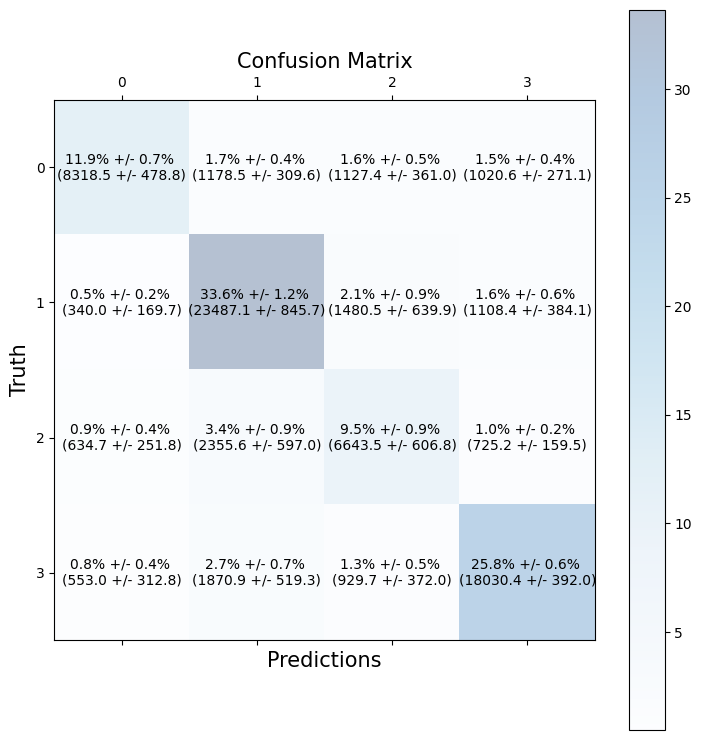

In [288]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix = np.mean(conf_mat,axis=0)
std_conf_matrix = np.std(conf_mat,axis=0)
non_norm_matrix = np.mean(non_norm_conf_mat,axis=0)
std_non_norm_matrix = np.std(non_norm_conf_mat,axis=0)

cmap = ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s="%1.1f%% +/- %1.1f%% \n(%1.1f +/- %1.1f)"%(conf_matrix[i, j],
                                                                      std_conf_matrix[i, j],
                                                                      non_norm_matrix[i, j],
                                                                      std_non_norm_matrix[i, j]
                                                                     ), 
                va='center', ha='center')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion Matrix', fontsize=15);
fig.colorbar(cmap);
plt.tight_layout()
plt.show()

Repare que a eficiência da classe 3 está bastante degradada.

## Mostrar Lofar

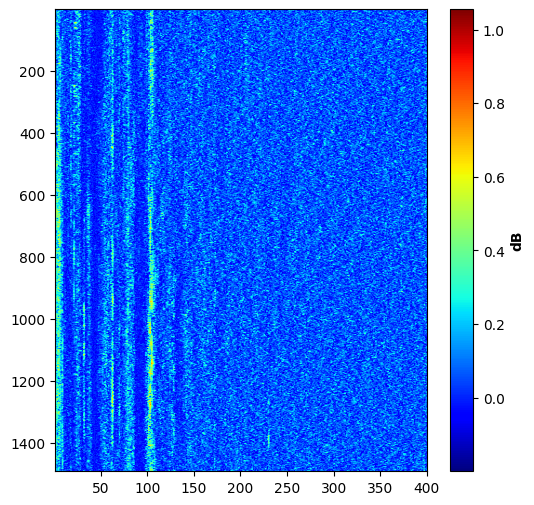

In [289]:
# Selecionando uma run
import matplotlib.pyplot as plt
selected_run = 'navio30'
fig, ax= plt.subplots(figsize=(6,6))
plot_data = df_all_data[df_all_data['run']==selected_run].filter(like='bin_').values
plt.imshow(plot_data,
           cmap="jet",extent=[1, 400, plot_data.shape[0],1],
           aspect="auto")
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB',fontweight='bold');